In [39]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


## Data Cleaning Functions

In [12]:
# Define a function to extract different date types from 'Listed_Fire_Dates'
def extract_dates(listed_dates):
    if pd.isna(listed_dates):
        return {}
    date_matches = re.findall(r'(\w+ \w+ Date\(s\)): (\d{4}-\d{2}-\d{2})', listed_dates)
    return {match[0]: match[1] for match in date_matches}


# Create a function to extract a trusted start date from a row
def get_trusted_start_date(row: pd.Series) -> datetime:
    """
    Extract a trusted start date from a row by checking specific
    start date columns that match the fire year.

    Parameters
    ----------
    row : pd.Series
        A row of the DataFrame containing fire information,
        including multiple start date columns.

    Returns
    -------
    datetime or pd.NaT
        The trusted start date that matches the fire year, or
        pd.NaT if no matching date is found.
    """
    fire_year = row['Fire_Year']
    start_date_columns = [
        "Wildfire Discovery Date(s)",
        "Fire Start Date(s)",
        "Listed Ignition Date(s)"
    ]
    
    for col in start_date_columns:
        date_str = row.get(col)
        
        if pd.notna(date_str):
            try:
                # Use datetime.strptime to parse the date string
                date_obj = datetime.strptime(date_str, "%Y-%m-%d")
                if date_obj.year == fire_year:
                    return date_obj
            except ValueError:
                continue
    return pd.NaT

# Create a function to extract a trusted end date from a row
def get_trusted_end_date(row: pd.Series) -> datetime:
    """
    Extract a trusted end date from a row by checking specific
    end date columns that match the fire year.

    Parameters
    ----------
    row : pd.Series
        A row of the DataFrame containing fire information,
        including multiple end date columns.

    Returns
    -------
    datetime
        The trusted end date that matches the fire year, or
        October 31 of the fire year if no matching date is found.
    """
    fire_year = row['Fire_Year']
    end_date_columns = [
        "Wildfire Out Date(s)",
        "Fire End Date(s)"
    ]
    
    for col in end_date_columns:
        date_str = row.get(col)
        
        if pd.notna(date_str):
            try:
                # Use datetime.strptime to parse the date string
                date_obj = datetime.strptime(date_str, "%Y-%m-%d")
                if date_obj.year == fire_year:
                    return date_obj
            except ValueError:
                continue
    
    # Default to October 31 of the fire year if no matching date is found
    return datetime(fire_year, 10, 31)

### Load and Clean the wildfire data

In [3]:
widfire_csv = 'fires_within_range_subset_columns.csv'
wildfire_csv_path = r"C:\Users\clark.roll\python coding\code_personal\Data512_ProjectDataset"
csv_filepath = os.path.join(wildfire_csv_path, widfire_csv)
df = pd.read_csv(csv_filepath)

In [4]:
df

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Notes,Processing_Notes,closest_distance_miles,average_distance_miles,centroid,perimeter_points_count,closest_point
0,13526,Wildfire,1961,55249.740141,Listed Wildfire Discovery Date(s): 1961-09-08 ...,14 - Unknown / Unidentified (2),Undetermined (10),NaN,NaN,0.024178,0.024248,"(40.3071597116488, -122.01073305780703)",300,"(40.270378634833435, -121.90349064900796)"
1,13527,Wildfire,1961,43920.841077,Listed Wildfire Discovery Date(s): 1961-07-10 ...,"9 - Miscellaneous (1), 14 - Unknown / Unidenti...","Undetermined (9), Human (1)",NaN,NaN,0.022415,0.022424,"(37.273369562124806, -119.6884846315714)",339,"(37.26817411703421, -119.67551797835266)"
2,13528,Wildfire,1961,34233.698600,Listed Wildfire Discovery Date(s): 1961-09-02 ...,14 - Unknown / Unidentified (2),Undetermined (10),NaN,NaN,0.023157,0.023238,"(38.435212264140354, -120.78787068074449)",260,"(38.44797965297809, -120.6523182350517)"
3,13529,Wildfire,1961,32866.053451,Listed Wildfire Discovery Date(s): 1961-07-12 ...,14 - Unknown / Unidentified (1),Undetermined (5),NaN,NaN,0.023430,0.023500,"(37.22045086951671, -121.46047676557103)",154,"(37.227942613032596, -121.34492892188251)"
4,13530,Wildfire,1961,27269.045936,Listed Wildfire Discovery Date(s): 1961-09-01 ...,NaN,Undetermined (3),NaN,NaN,0.023534,0.023578,"(44.95547648182331, -119.31721242095391)",742,"(44.922864832018575, -119.2537443114835)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53925,135010,Prescribed Fire,2020,4143.012270,Listed Prescribed Fire Start Date(s): 2020-05-...,Human (1),Human (1),NaN,NaN,0.019219,0.019231,"(44.44619485915349, -111.8579807785818)",17,"(44.448183276745084, -111.83619087180149)"
53926,135017,Prescribed Fire,2020,206.093386,Listed Prescribed Fire Start Date(s): 2020-08-...,Human (1),Human (1),NaN,NaN,0.013349,0.013354,"(33.50948036661952, -105.52334024861784)",154,"(33.51288574833502, -105.51482510186779)"
53927,135028,Prescribed Fire,2020,77.245054,Listed Prescribed Fire Start Date(s): 2020-05-...,Human (1),Human (1),NaN,NaN,0.024732,0.024734,"(40.64525148341933, -122.73079157889296)",99,"(40.64955640867976, -122.72661823729933)"
53928,135047,Prescribed Fire,2020,19.824395,Listed Prescribed Fire Start Date(s): 2020-06-...,Human (1),Human (1),NaN,NaN,0.022755,0.022757,"(47.49264393386596, -116.6728882084781)",40,"(47.4903027051776, -116.67044525458091)"


## Calculate a few new fields for the smoke model

Calculate start and end dates so we can get the fire duration

In [8]:
# Apply the function to the 'Listed_Fire_Dates' column and create new columns based on the extracted dates
dates_extracted = df['Listed_Fire_Dates'].apply(extract_dates)
dates_df = pd.DataFrame(dates_extracted.tolist())

# Concatenate the original subset DataFrame with the new extracted date columns
df = pd.concat([df, dates_df], axis=1)

In [13]:
# Apply the function to each row to create the 'Trusted_Date' column
df['Trusted_Start_Date'] = df.apply(get_trusted_start_date, axis=1)
df['Trusted_End_Date']   = df.apply(get_trusted_end_date,   axis=1)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Dates,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Notes,Processing_Notes,closest_distance_miles,...,Other Fire Date(s),Wildfire Controlled Date(s),Listed Upload Date(s),Wildfire Containment Date(s),Wildfire Out Date(s),Fire Start Date(s),Fire End Date(s),Listed Ignition Date(s),Trusted_Start_Date,Trusted_End_Date
0,13526,Wildfire,1961,55249.740141,Listed Wildfire Discovery Date(s): 1961-09-08 ...,14 - Unknown / Unidentified (2),Undetermined (10),NaN,NaN,0.024178,...,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961-09-08,1961-10-31
1,13527,Wildfire,1961,43920.841077,Listed Wildfire Discovery Date(s): 1961-07-10 ...,"9 - Miscellaneous (1), 14 - Unknown / Unidenti...","Undetermined (9), Human (1)",NaN,NaN,0.022415,...,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961-07-10,1961-10-31
2,13528,Wildfire,1961,34233.698600,Listed Wildfire Discovery Date(s): 1961-09-02 ...,14 - Unknown / Unidentified (2),Undetermined (10),NaN,NaN,0.023157,...,1899-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961-09-02,1961-10-31
3,13529,Wildfire,1961,32866.053451,Listed Wildfire Discovery Date(s): 1961-07-12 ...,14 - Unknown / Unidentified (1),Undetermined (5),NaN,NaN,0.023430,...,1961-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961-07-12,1961-10-31
4,13530,Wildfire,1961,27269.045936,Listed Wildfire Discovery Date(s): 1961-09-01 ...,NaN,Undetermined (3),NaN,NaN,0.023534,...,2017-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961-09-01,1961-10-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53925,135010,Prescribed Fire,2020,4143.012270,Listed Prescribed Fire Start Date(s): 2020-05-...,Human (1),Human (1),NaN,NaN,0.019219,...,NaN,NaN,2021-06-04,NaN,NaN,2020-05-01,2020-07-30,NaN,2020-05-01,2020-07-30
53926,135017,Prescribed Fire,2020,206.093386,Listed Prescribed Fire Start Date(s): 2020-08-...,Human (1),Human (1),NaN,NaN,0.013349,...,NaN,NaN,2020-11-06,NaN,NaN,2020-08-12,2020-08-20,NaN,2020-08-12,2020-08-20
53927,135028,Prescribed Fire,2020,77.245054,Listed Prescribed Fire Start Date(s): 2020-05-...,Human (1),Human (1),NaN,NaN,0.024732,...,NaN,NaN,2020-12-04,NaN,NaN,2020-05-01,2020-05-02,NaN,2020-05-01,2020-05-02
53928,135047,Prescribed Fire,2020,19.824395,Listed Prescribed Fire Start Date(s): 2020-06-...,Human (1),Human (1),NaN,NaN,0.022755,...,NaN,NaN,2021-03-05,NaN,NaN,2020-06-20,NaN,NaN,2020-06-20,2020-10-31


In [15]:
# Calculate fire duration in days
df['duration_days'] = (df['Trusted_End_Date'] - df['Trusted_Start_Date']).dt.days

Simplify the fire type 

In [18]:
# Mapping rules for 'smoke prediction fire type'
fire_type_mapping = {
    'Wildfire': 'Wildfire',
    'Unknown - Likely Wildfire': 'Wildfire',
    'Likely Wildfire': 'Wildfire',
    'Prescribed Fire': 'Prescribed Fire',
    'Unknown - Likely Prescribed Fire': 'Prescribed Fire'
}

# Generate the 'smoke prediction fire type' column based on the mapping
df['smoke_prediction_fire_type'] = df['Assigned_Fire_Type'].map(fire_type_mapping).fillna('Other')

## Create the models

### Historical Smoke Impact Score

Calculate the smoke impact score for every fire

In [21]:
# Define weights for each fire type
fire_type_weights = {
    'Wildfire': 1.0,
    'Prescribed Fire': 0.5
}

# Map the fire type to the corresponding weight
df['fire_type_weight'] = df['smoke_prediction_fire_type'].map(fire_type_weights)

In [22]:
# Calculate the smoke impact score with fire type weight included
df['smoke_impact'] = (df['GIS_Acres'] * df['duration_days'] * df['fire_type_weight']) / df['closest_distance_miles']

Aggregate the total smoke impact score per year

In [52]:
# Aggregate the total smoke impact score per year
annual_smoke_impact = df.groupby('Fire_Year')['smoke_impact'].sum().reset_index()
annual_smoke_impact.columns = ['Year', 'Smoke Impact Score']
annual_smoke_impact['Year'] = pd.to_datetime(annual_smoke_impact['Year'], format='%Y')

In [53]:
annual_smoke_impact

,Year,Smoke Impact Score
0,1961-01-01,1.409437e+09
1,1962-01-01,4.318445e+08
2,1963-01-01,6.807682e+08
3,1964-01-01,8.317814e+08
4,1965-01-01,4.752171e+08
5,1966-01-01,1.541542e+09
6,1967-01-01,4.206183e+08
7,1968-01-01,1.042588e+09
8,1969-01-01,1.006609e+09
9,1970-01-01,1.514003e+09


## Predictive Model into the future!

In [54]:
# Prepare data for linear regression
X = annual_smoke_impact['Year'].dt.year.values.reshape(-1, 1)  # Convert Year to integer and reshape for sklearn
y = annual_smoke_impact['Smoke Impact Score'].values  # Target variable

# Train the linear regression model
model_lr = LinearRegression().fit(X, y)

# Forecast for the next 25 years (2025-2050)
future_years = np.arange(2025, 2051).reshape(-1, 1)  # Years to forecast
forecast_lr = model_lr.predict(future_years)

In [55]:
# Combine historical and forecasted data for plotting
historical_data = pd.DataFrame({'Year': X.flatten(), 'Smoke Impact Score': y})
forecast_data = pd.DataFrame({'Year': future_years.flatten(), 'Smoke Impact Score': forecast_lr})

In [58]:
# Compute confidence intervals
# Calculate predictions on training data to get residuals
predictions_train = model_lr.predict(X)
residuals = y - predictions_train
std_error = np.std(residuals)  # Standard deviation of residuals

# 95% confidence interval (1.96 * std_error for normal distribution)
confidence_interval = 1.96 * std_error

In [59]:
# Compute upper and lower bounds for the confidence intervals
forecast_lower = forecast_lr - confidence_interval
forecast_upper = forecast_lr + confidence_interval

In [60]:
# Combine historical and forecasted data for plotting
historical_data = pd.DataFrame({'Year': X.flatten(), 'Smoke Impact Score': y})
forecast_data = pd.DataFrame({
    'Year': future_years.flatten(),
    'Forecasted Smoke Impact': forecast_lr,
    'Lower CI': forecast_lower,
    'Upper CI': forecast_upper
})

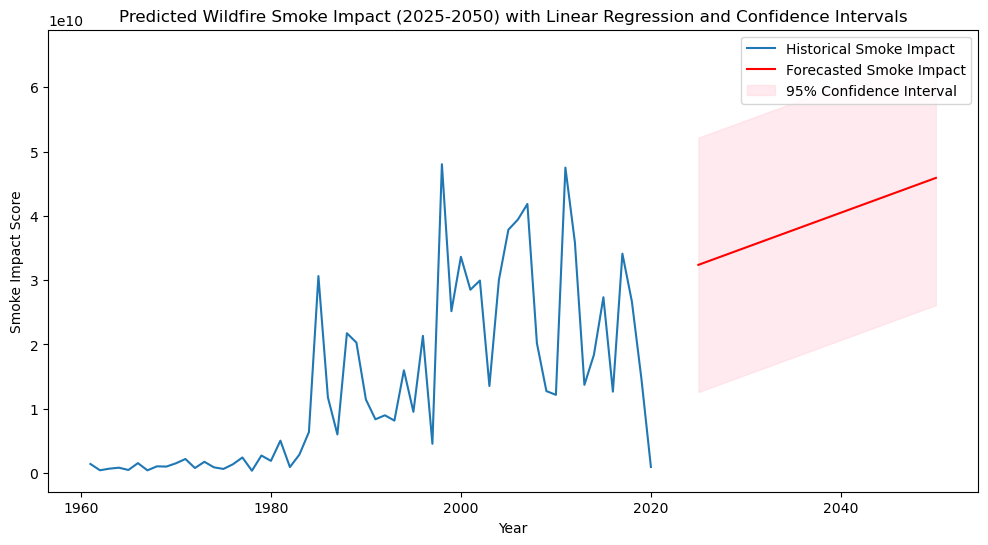

In [61]:
# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=historical_data, x='Year', y='Smoke Impact Score', label='Historical Smoke Impact')
sns.lineplot(data=forecast_data, x='Year', y='Forecasted Smoke Impact', color='red', label='Forecasted Smoke Impact')
plt.fill_between(forecast_data['Year'], forecast_data['Lower CI'], forecast_data['Upper CI'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Score')
plt.title('Predicted Wildfire Smoke Impact (2025-2050) with Linear Regression and Confidence Intervals')
plt.legend()
plt.show()